# A gentle introduction to backtesting

We started this series by introducing some indicators based on price. Our goal is to use indicators, along with price and volume, to make investment decisions: to choose when to buy or sell a financial asset.
There are different ways we can incorporate price, volume, and indicators in our investment decision process. The first, the most traditional, is to interpret their patterns in a discretional way, as followers of [Technical Analysis](https://en.wikipedia.org/wiki/Technical_analysis) do.
Indicators can also be employed in a more quantitative approach as building blocks of a trading system that removes human discretion from the investment process. [Algorithmic Trading](https://en.wikipedia.org/wiki/Algorithmic_trading), in particular, is an approach based on trading strategies that take positions in financial instruments on their own without human intervention. We can also use price, volume, and indicators as part of a more complex machine learning model for our investment decisions.

Whatever way we choose to use our indicators, we need to answer an important question: how good are our indicators, or combinations of indicators, to inform our investment decisions? In other words, will the use of any indicator lead to better results than not using them at all?

A process that can help us to answer this question is known as [**backtesting**](https://www.investopedia.com/terms/b/backtesting.asp). With backtesting, we apply a trading or investment strategy to historical data to generate hypothetical results. We can then analyze those results to evaluate the profitability and the risk of our strategy.

This process has its own pitfalls: there is no guarantee that a strategy that performed well on historical data will perform well in real trading. Real trading involves many factors that cannot be simulated or tested on historical data. Also, since financial markets keep evolving fast, the future may exhibit patterns not present in historical data. However, if a strategy cannot prove itself valid in a backtest most probably will never work in real trading. Backtesting can at least help us to weed out the strategies that do not prove themselves worthy.

Several frameworks make it easy to backtest trading strategies using Python. Two popular examples are [**Zipline**](https://www.zipline.io/) and [**Backtrader**](https://www.backtrader.com/). Frameworks like *Zipline* and *Backtrader* include all the tools needed to design, test, and implement an algorithmic trading strategy. They can even automate the submission of real orders to an execution broker.

With this article, we are taking a different approach: we want to investigate how to build and test a trading system from scratch using Python, *pandas*, and NumPy as our only tools. Why should we want to do that?
To start with, building a backtest from scratch is an excellent exercise and will help to understand in detail how a strategy works. Also, we may find ourselves in situations where we need to implement solutions not available in existing frameworks. Or, you may want to embark on the journey of creating your own backtesting framework!

## Backtesting our first system

We can create a barebone backtest using Python with NumPy and *pandas*. To build an example, we are going to use prices for the *Campbell Soup Company* stock (**CPB**) traded on the NYSE. I downloaded five years of trading history from [Yahoo! Finance](https://uk.finance.yahoo.com/quote/CPB): the file is available [here](https://raw.githubusercontent.com/stebas101/TradingToolbox/master/data/CPB.csv).

We start by setting up our environment and load the price series into a data frame:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()

# This is needed if you're using Jupyter to visualize charts:
%matplotlib inline

import sys
import matplotlib as mpl
import mplfinance as mpf
print(f"Python version: {sys.version}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"mplfinanceversion: {mpf.__version__}")

datafile = 'data/CPB.csv'
data = pd.read_csv(datafile, index_col = 'Date')
data.index = pd.to_datetime(data.index) # Converting the dates from string to datetime format

data

Python version: 3.7.7 (default, May  6 2020, 04:59:01) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas version: 1.1.0
numpy version: 1.19.1
mplfinanceversion: 0.12.7a0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-09-02,47.389999,47.770000,47.009998,47.770000,41.054787,2547200
2015-09-03,46.910000,48.680000,46.070000,48.529999,41.707958,2364100
2015-09-04,48.230000,48.500000,47.439999,47.939999,41.200890,2019300
2015-09-08,48.500000,49.410000,48.500000,49.380001,42.438469,2458700
2015-09-09,49.779999,49.779999,48.590000,48.720001,41.871243,2198900
...,...,...,...,...,...,...
2020-08-26,52.900002,53.500000,52.389999,53.480000,53.480000,1375400
2020-08-27,53.509998,54.080002,53.259998,53.290001,53.290001,1432100
2020-08-28,53.290001,53.290001,51.930000,52.139999,52.139999,1827300


### A basic strategy

For our example, we are going to test a basic **moving average crossover system** based on a 20-day Exponential Moving Average (EMA) and a 200-day Simple Moving Average (SMA) of the daily closing price (using *Adjusted Close* in this example). We are going to buy the stock (take a *long position*) whenever the 20-day EMA crosses the 200-day SMA from below.

We add columns with our moving averages to the data frame:

In [2]:
df = data.copy()

sma_span = 200
ema_span = 20

df['sma200'] = df['Adj Close'].rolling(sma_span).mean()
df['ema20'] = df['Adj Close'].ewm(span=ema_span).mean()

df.round(3)

,Open,High,Low,Close,Adj Close,Volume,sma200,ema20
Date,,,,,,,,
2015-09-02,47.39,47.77,47.01,47.77,41.055,2547200,NaN,41.055
2015-09-03,46.91,48.68,46.07,48.53,41.708,2364100,NaN,41.398
2015-09-04,48.23,48.50,47.44,47.94,41.201,2019300,NaN,41.325
2015-09-08,48.50,49.41,48.50,49.38,42.438,2458700,NaN,41.647
2015-09-09,49.78,49.78,48.59,48.72,41.871,2198900,NaN,41.701
...,...,...,...,...,...,...,...,...
2020-08-26,52.90,53.50,52.39,53.48,53.480,1375400,48.478,51.571
2020-08-27,53.51,54.08,53.26,53.29,53.290,1432100,48.519,51.735
2020-08-28,53.29,53.29,51.93,52.14,52.140,1827300,48.553,51.773


As we can see, by using a 200-day SMA we get **NaN** values in the first 199 rows for the respective column. This is just an exercise, and we can just get rid of those rows to perform our backtest. In real practice, we may consider using a different indicator to avoid losing so much data. To remove the *NaN* values:

In [3]:
df.dropna(inplace=True)

df.round(3)

,Open,High,Low,Close,Adj Close,Volume,sma200,ema20
Date,,,,,,,,
2016-06-17,62.75,62.75,61.87,62.44,54.582,2064300,49.113,54.320
2016-06-20,62.63,63.15,62.39,62.41,54.556,1459400,49.181,54.343
2016-06-21,62.65,63.21,62.49,62.85,54.940,1161900,49.247,54.400
2016-06-22,63.08,63.08,62.23,62.59,54.713,1395800,49.314,54.429
2016-06-23,62.68,62.92,62.27,62.64,54.757,1177000,49.376,54.461
...,...,...,...,...,...,...,...,...
2020-08-26,52.90,53.50,52.39,53.48,53.480,1375400,48.478,51.571
2020-08-27,53.51,54.08,53.26,53.29,53.290,1432100,48.519,51.735
2020-08-28,53.29,53.29,51.93,52.14,52.140,1827300,48.553,51.773


Let's have a look at our data in a chart:

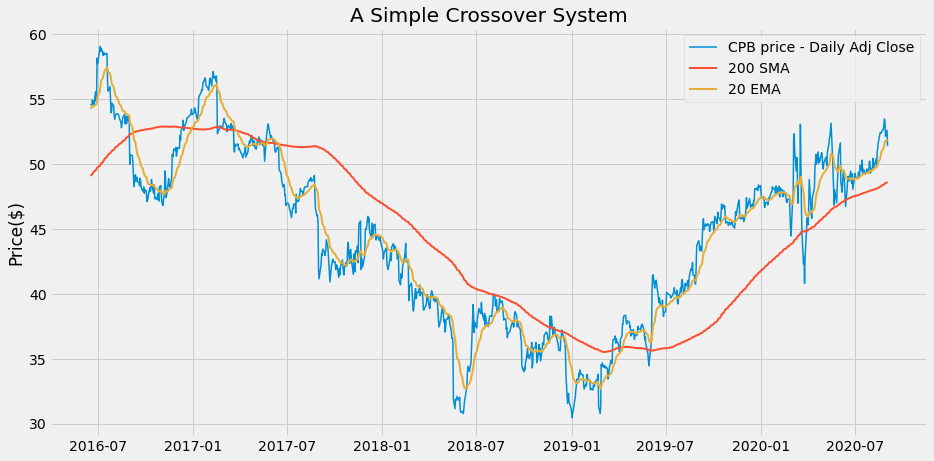

In [4]:
def plot_system1(data):
    df = data.copy()
    dates = df.index
    price = df['Adj Close']
    sma200 = df['sma200']
    ema20 = df['ema20']
    
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(14,7))
        plt.plot(dates, price, linewidth=1.5, label='CPB price - Daily Adj Close')
        plt.plot(dates, sma200, linewidth=2, label='200 SMA')
        plt.plot(dates, ema20, linewidth=2, label='20 EMA')
        plt.title("A Simple Crossover System")
        plt.ylabel('Price($)')
        plt.legend()
    
    plt.show() # This is needed only if not in Jupyter

plot_system1(df)

To keep track of our positions in the data frame we add a column that contains, for each row, the number **1** for the days when we have a long position and the number **0** for the days when we have no position:

In [5]:
# Our trading condition:
long_positions = np.where(df['ema20'] > df['sma200'], 1, 0)
df['Position'] = long_positions

df.round(3)

,Open,High,Low,Close,Adj Close,Volume,sma200,ema20,Position
Date,,,,,,,,,
2016-06-17,62.75,62.75,61.87,62.44,54.582,2064300,49.113,54.320,1
2016-06-20,62.63,63.15,62.39,62.41,54.556,1459400,49.181,54.343,1
2016-06-21,62.65,63.21,62.49,62.85,54.940,1161900,49.247,54.400,1
2016-06-22,63.08,63.08,62.23,62.59,54.713,1395800,49.314,54.429,1
2016-06-23,62.68,62.92,62.27,62.64,54.757,1177000,49.376,54.461,1
...,...,...,...,...,...,...,...,...,...
2020-08-26,52.90,53.50,52.39,53.48,53.480,1375400,48.478,51.571,1
2020-08-27,53.51,54.08,53.26,53.29,53.290,1432100,48.519,51.735,1
2020-08-28,53.29,53.29,51.93,52.14,52.140,1827300,48.553,51.773,1


Whatever rule we are trying to implement, it's a good idea to **inspect our signals** to make sure that everything works as intended. Pesky mistakes like to hide inside this kind of computations: it's way too easy to start testing a system, only to discover later that we did not implement our rules correctly. In particular, we need to be wary of introducing any form of **look-ahead bias**: this happens when we include in our trading rule data that is not actually available at the time the rule is evaluated. If a system backtest produces results that are too good to be true, look-ahead bias is the most likely culprit.

We can inspect our signals by checking the numeric variables in our data frame and by plotting the signals on a chart.

To select the days when the trading signal is triggered:

In [6]:
buy_signals = (df['Position'] == 1) & (df['Position'].shift(1) == 0)

df.loc[buy_signals].round(3)

,Open,High,Low,Close,Adj Close,Volume,sma200,ema20,Position
Date,,,,,,,,,
2016-12-30,60.93,61.09,60.33,60.47,53.802,1204500,52.734,52.833,1
2017-05-25,58.45,58.86,57.65,58.83,52.975,1858600,51.651,51.778,1
2019-04-10,39.19,39.57,38.91,39.13,37.678,2936200,35.912,36.021,1


We have only three signals in this case. To make sure that we are applying the crossover trading rule correctly, we can include the days before the signals in the selection:

In [7]:
buy_signals_prev = (df['Position'].shift(-1) == 1) & (df['Position'] == 0)

df.loc[buy_signals | buy_signals_prev].round(3)

,Open,High,Low,Close,Adj Close,Volume,sma200,ema20,Position
Date,,,,,,,,,
2016-12-29,60.56,61.02,60.48,60.95,54.229,940200,52.745,52.731,0
2016-12-30,60.93,61.09,60.33,60.47,53.802,1204500,52.734,52.833,1
2017-05-24,58.16,58.43,57.93,58.38,52.570,2204000,51.655,51.652,0
2017-05-25,58.45,58.86,57.65,58.83,52.975,1858600,51.651,51.778,1
2019-04-09,38.46,39.81,38.46,39.49,37.688,5173300,35.903,35.846,0
2019-04-10,39.19,39.57,38.91,39.13,37.678,2936200,35.912,36.021,1


Everything looks good so far: on the days before the signal, `ema20` is below `sma200`, and it crosses above on the signal days. We can do a similar inspection for the signals to exit our positions: I leave this exercise to you.

We can plot markers for our signals on a chart:

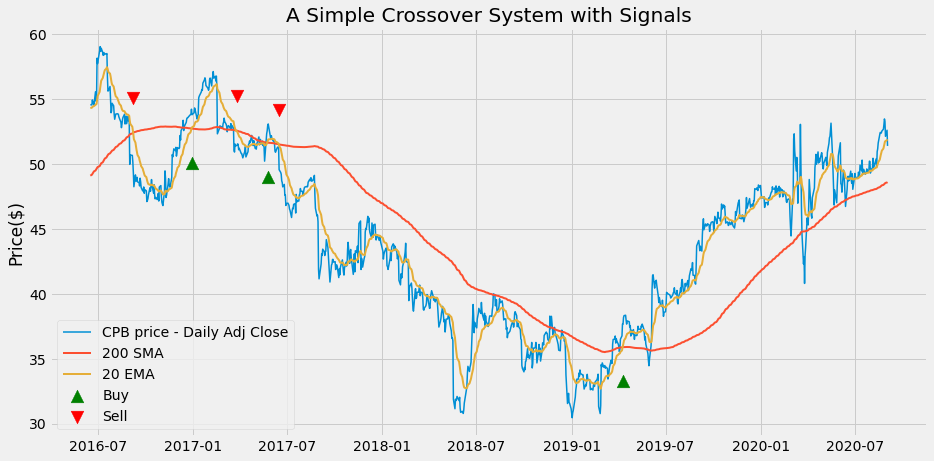

In [8]:
def plot_system1_sig(data):
    df = data.copy()
    dates = df.index
    price = df['Adj Close']
    sma200 = df['sma200']
    ema20 = df['ema20']
    
    buy_signals = (df['Position'] == 1) & (df['Position'].shift(1) == 0)
    buy_marker = sma200 * buy_signals - (sma200.max()*.05)
    buy_marker = buy_marker[buy_signals]
    buy_dates = df.index[buy_signals]
    sell_signals = (df['Position'] == 0) & (df['Position'].shift(1) == 1)
    sell_marker = sma200 * sell_signals + (sma200.max()*.05)
    sell_marker = sell_marker[sell_signals]
    sell_dates = df.index[sell_signals]
    
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(14,7))
        plt.plot(dates, price, linewidth=1.5, label='CPB price - Daily Adj Close')
        plt.plot(dates, sma200, linewidth=2, label='200 SMA')
        plt.plot(dates, ema20, linewidth=2, label='20 EMA')
        plt.scatter(buy_dates, buy_marker, marker='^', color='green', s=160, label='Buy')
        plt.scatter(sell_dates, sell_marker, marker='v', color='red', s=160, label='Sell')
        plt.title("A Simple Crossover System with Signals")
        plt.ylabel('Price($)')
        plt.legend()
    
    plt.show() # This is needed only if not in Jupyter

plot_system1_sig(df)

From the chart, we can see that there is a mismatch between Buy and Sell signals. The first signal is a Sell (without a Buy) since we start from a long position at the beginning of the series. The last signal is a Buy (without a Sell) because we keep a long position at the end of the series.

### Strategy returns

We can now compute the return for our strategy as a percentage of the initial investment and compare it to the returns of a *Buy and Hold* strategy that simply buys our stock at the beginning of the period and holds it until the end.

The price series that we are going to use to calculate the returns is **Adjusted Close**: by using an adjusted price we make sure that the effects of dividends, stock splits, and other [corporate actions](https://www.investopedia.com/articles/03/081303.asp) on returns are taken into account in our calculation.

In [9]:
# The returns of the Buy and Hold strategy:
df['Hold'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# The returns of the Moving Average strategy:
df['Strategy'] = df['Position'].shift(1) * df['Hold']

# We need to get rid of the NaN generated in the first row:
df.dropna(inplace=True)

df

,Open,High,Low,Close,Adj Close,Volume,sma200,ema20,Position,Hold,Strategy
Date,,,,,,,,,,,
2016-06-20,62.630001,63.150002,62.389999,62.410000,54.555550,1459400,49.180615,54.342710,1,-0.000481,-0.000481
2016-06-21,62.650002,63.209999,62.490002,62.849998,54.940170,1161900,49.246776,54.399611,1,0.007025,0.007025
2016-06-22,63.080002,63.080002,62.230000,62.590000,54.712894,1395800,49.314336,54.429448,1,-0.004145,-0.004145
2016-06-23,62.680000,62.919998,62.270000,62.639999,54.756611,1177000,49.375926,54.460606,1,0.000799,0.000799
2016-06-24,61.450001,63.490002,61.049999,62.400002,54.546814,3845400,49.439304,54.468816,1,-0.003839,-0.003839
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,52.900002,53.500000,52.389999,53.480000,53.480000,1375400,48.478148,51.571117,1,0.008450,0.008450
2020-08-27,53.509998,54.080002,53.259998,53.290001,53.290001,1432100,48.519216,51.734820,1,-0.003559,-0.003559
2020-08-28,53.290001,53.290001,51.930000,52.139999,52.139999,1827300,48.553018,51.773409,1,-0.021816,-0.021816


The returns for the whole period are simply a sum of the daily log returns:

In [10]:
returns = np.exp(df[['Hold', 'Strategy']].sum()) - 1

print(f"Buy and hold return: {round(returns['Hold']*100,2)}%")
print(f"Strategy return: {round(returns['Strategy']*100,2)}%")

Buy and hold return: -5.83%
Strategy return: 10.3%


Those returns are related to a period of 1060 days. If we want to compare them to returns from other periods we need to **annualize** them:

In [11]:
n_days = len(df)

# Assuming 252 trading days in a year:
ann_returns = 252 / n_days * returns

print(f"Buy and hold annualized return: {round(ann_returns['Hold']*100,2)}%")
print(f"Strategy annualized return: {round(ann_returns['Strategy']*100,2)}%")

Buy and hold annualized return: -1.39%
Strategy annualized return: 2.45%


So far, our simple strategy seems to do better than to *buy and hold*: this particular stock had a negative trend over the period, while the simple MA crossover strategy gave us a return in excess of 10%. I have actually chosen that stock series on purpose: it has a bearish trend at the beginning of the period before turning bullish. Do not expect to be always so lucky with the results!

Unless you are familiar with log returns, you may wonder why and how we used **logarithms** in the return calculations. Here is a bit of maths to explain that in case that sounds all new to you. Otherwise, feel free to skip to the next section.

In quantitative finance it's very common to use logarithms to calculate returns: they make some computations easier to handle. If the daily return **$R_t$** is defined as:

$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

where $P_t$ is the price at date $t$, the logarithmic return $r_t$ is defined as:

$$r_t = \ln (1 + R_t)$$

By applying some basic algebra, it's possible to compute the daily log return as:

$$r_t = \ln \frac{P_t}{P_{t-1}} =  \ln P_t - \ln P_{t-1}$$

Why are log-returns handy? If we have a series of daily returns and we need to calculate the return for the whole period, with log returns we can make a sum of them By contrast, with regular returns, we need to a multiplication:

$$\text{Return over the period} =  (1+R_1)\times(1+R_2)\times\dots\times(1+R_T) = \exp \left( \sum_{t=0}^{T} r_t \right)$$

where *T* is the number of days in the period of time that we are considering. Calculating the annualized returns comes easier as well.

## A more complex strategy

The strategy we have just tested had only two possible positions: we were either *long* (holding the stock) or *flat* (holding just cash). It would be interesting to try and test a strategy that adds the possibility of a *short* position as well (selling borrowed shares and buying them back when exiting the position). To build an example of this strategy we include two simple moving averages, one for the daily highs, and one for the daily lows. We also add a 15-day exponential moving average.
We take positions based on the following rules:
- when the EMA is above the higher SMA (plus a 2% offset), we take a long position (buy)
- when the EMA is below the lower SMA (minus a 2% offset), we take a short position (sell short)
- in all other situations (EMA between the to SMAs), we keep out of the market

I added the offset to the SMAs to reduce the numbers of false signals. Let's prepare a new data frame:

In [12]:
df2 = data.copy()

sma_span = 40
ema_span = 15

df2['H_sma'] = df2['High'].rolling(sma_span).mean()
df2['L_sma'] = df2['Low'].rolling(sma_span).mean()
df2['C_ema'] = df2['Close'].ewm(span=ema_span).mean()

df2.dropna(inplace=True)

df2.round(3)

,Open,High,Low,Close,Adj Close,Volume,H_sma,L_sma,C_ema
Date,,,,,,,,,
2015-10-28,51.27,51.38,50.33,50.79,43.917,1368900,50.745,49.844,50.660
2015-10-29,50.69,51.37,50.38,51.20,44.272,1035700,50.835,49.928,50.728
2015-10-30,51.11,51.45,50.78,50.79,43.917,1184300,50.904,50.046,50.735
2015-11-02,50.88,50.99,50.36,50.74,43.874,1169700,50.966,50.119,50.736
2015-11-03,50.50,50.75,49.70,50.23,43.433,1278200,51.000,50.149,50.673
...,...,...,...,...,...,...,...,...,...
2020-08-26,52.90,53.50,52.39,53.48,53.480,1375400,50.791,49.927,51.923
2020-08-27,53.51,54.08,53.26,53.29,53.290,1432100,50.897,50.029,52.094
2020-08-28,53.29,53.29,51.93,52.14,52.140,1827300,50.983,50.100,52.100


Here we are making use of High and Low prices in addition to Close prices. To plot those values on a chart, it's a good idea to use [**OHLC bars** or **candlesticks**](https://towardsdatascience.com/trading-toolbox-03-ohlc-charts-95b48bb9d748). We are going to use the **mplfinance** library for this. If you have not done that yet, you can easily install *mplfinance* using:

```pip install --upgrade mplfinance```

To integrate the candlestick chart with our existing style, I am going to apply the [*External Axes Method*](https://github.com/matplotlib/mplfinance/blob/master/markdown/subplots.md#external-axes-method) of *mplfinance*:

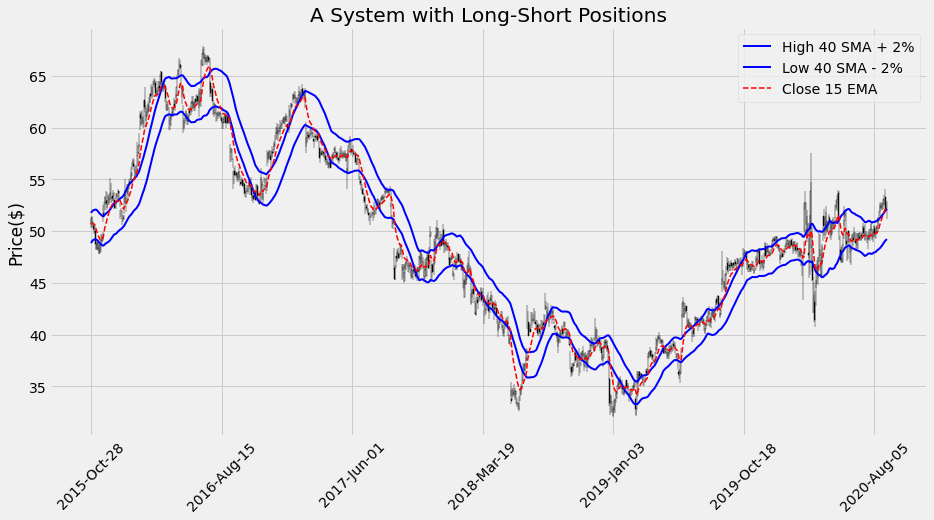

In [13]:
import mplfinance as mpf
import numpy as np

def plot_system2(data):
    df2 = data.copy()
    dates = np.arange(len(df2)) # We need this for mpl.plot()
    price = df2['Adj Close']
    h_sma = df2['H_sma']*1.02
    l_sma = df2['L_sma']*.98
    c_ema = df2['C_ema']
    
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(14,7))
        ax = plt.subplot(1,1,1)
        mpf.plot(df2, ax=ax, show_nontrading=False, type='candle')
        ax.plot(dates, h_sma, linewidth=2, color='blue', label='High 40 SMA + 2%')
        ax.plot(dates, l_sma, linewidth=2, color='blue', label='Low 40 SMA - 2%')
        ax.plot(dates, c_ema, linewidth=1.5, color='red', linestyle='--', label='Close 15 EMA')
        plt.title("A System with Long-Short Positions")
        ax.set_ylabel('Price($)')
        plt.legend()
    
    plt.show() # This is needed outside of Jupyter

plot_system2(df2)

We can examine more in detail any specific range of dates:

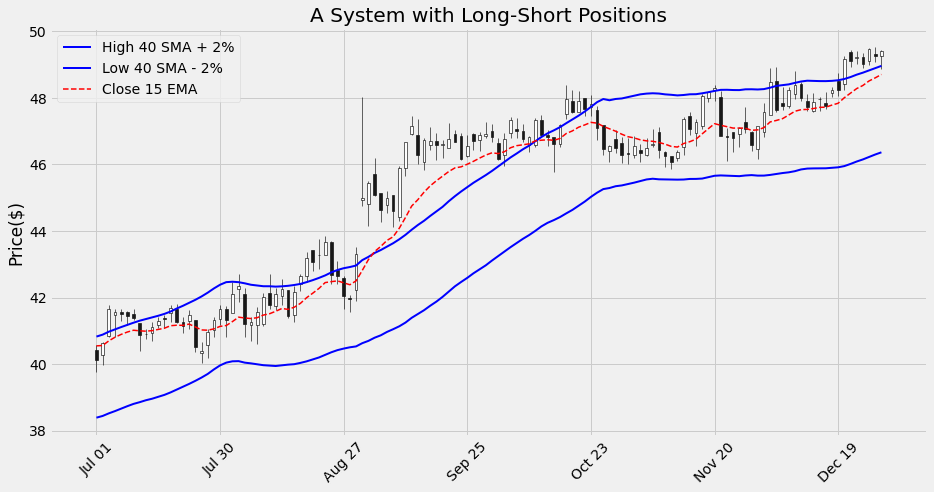

In [14]:
plot_system2(df2['2019-07-01':'2019-12-31'])

We then apply our trading rule and add the position columns:

In [15]:
offset = 0.02
long_positions = np.where(df2['C_ema'] > df2['H_sma']*(1+offset), 1, 0)
short_positions = np.where(df2['C_ema'] < df2['L_sma']*(1-offset), -1, 0)
df2['Position'] = long_positions + short_positions

df2.round(3)

,Open,High,Low,Close,Adj Close,Volume,H_sma,L_sma,C_ema,Position
Date,,,,,,,,,,
2015-10-28,51.27,51.38,50.33,50.79,43.917,1368900,50.745,49.844,50.660,0
2015-10-29,50.69,51.37,50.38,51.20,44.272,1035700,50.835,49.928,50.728,0
2015-10-30,51.11,51.45,50.78,50.79,43.917,1184300,50.904,50.046,50.735,0
2015-11-02,50.88,50.99,50.36,50.74,43.874,1169700,50.966,50.119,50.736,0
2015-11-03,50.50,50.75,49.70,50.23,43.433,1278200,51.000,50.149,50.673,0
...,...,...,...,...,...,...,...,...,...,...
2020-08-26,52.90,53.50,52.39,53.48,53.480,1375400,50.791,49.927,51.923,1
2020-08-27,53.51,54.08,53.26,53.29,53.290,1432100,50.897,50.029,52.094,1
2020-08-28,53.29,53.29,51.93,52.14,52.140,1827300,50.983,50.100,52.100,1


We can plot our signals on the chart:

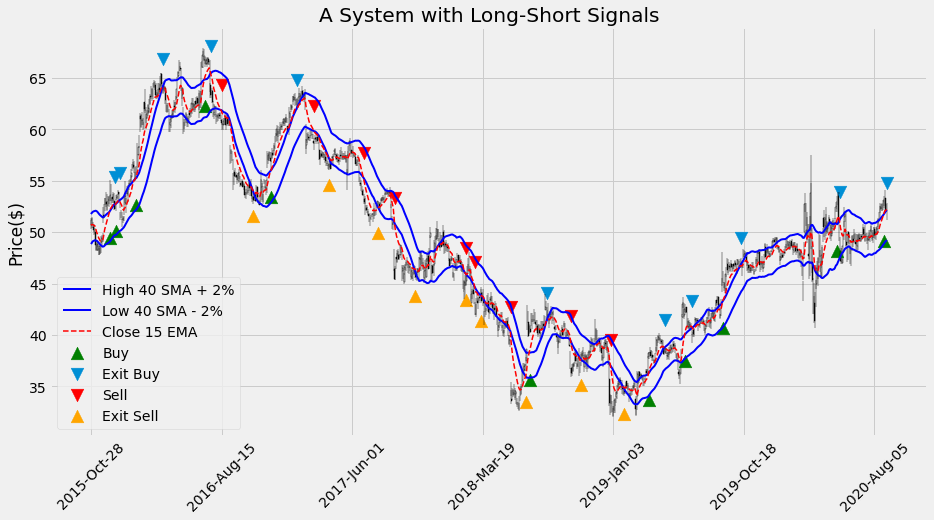

In [16]:
def plot_system2_sig(data):
    df2 = data.copy()
    dates = np.arange(len(df2)) # We need this for mpl.plot()
    price = df2['Adj Close']
    h_sma = df2['H_sma']*1.02
    l_sma = df2['L_sma']*.98
    c_ema = df2['C_ema']
    
    def reindex_signals(signals, markers):
        '''
        - takes two pd.Series (boolean, float)
        - returns signals and markers reindexed to an integer range, and their index
        '''
        signals.reset_index(drop=True, inplace=True)
        signals = signals[signals==True]
        dates = signals.index
        markers = markers[dates]
        markers.index = dates
        return signals, markers, dates
    
    buy_signals = (df2['Position'] == 1) & (df2['Position'].shift(1) != 1)
    buy_marker = h_sma * buy_signals[buy_signals==True] - (h_sma.max()*.04)
    buy_signals, buy_marker, buy_dates = reindex_signals(buy_signals, buy_marker)
    
    exit_buy_signals = (df2['Position'] != 1) & (df2['Position'].shift(1) == 1)
    exit_buy_marker = h_sma * exit_buy_signals + (h_sma.max()*.04)
    exit_buy_signals, exit_buy_marker, exit_buy_dates = reindex_signals(exit_buy_signals, exit_buy_marker)
    
    sell_signals = (df2['Position'] == -1) & (df2['Position'].shift(1) != -1)
    sell_marker = l_sma * sell_signals + (l_sma.max()*.04)
    sell_signals, sell_marker, sell_dates = reindex_signals(sell_signals, sell_marker)
    
    exit_sell_signals = (df2['Position'] != -1) & (df2['Position'].shift(1) == -1)
    exit_sell_marker = l_sma * exit_sell_signals - (l_sma.max()*.04)
    exit_sell_signals, exit_sell_marker, exit_sell_dates = reindex_signals(exit_sell_signals, exit_sell_marker)
    
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(14,7))
        ax = plt.subplot(1,1,1)
        mpf.plot(df2, ax=ax, show_nontrading=False, type='candle')
        ax.plot(dates, h_sma, linewidth=2, color='blue', label='High 40 SMA + 2%')
        ax.plot(dates, l_sma, linewidth=2, color='blue', label='Low 40 SMA - 2%')
        ax.plot(dates, c_ema, linewidth=1.5, color='red', linestyle='--', label='Close 15 EMA')
        ax.scatter(buy_dates, buy_marker, marker='^', color='green', s=160, label='Buy')
        ax.scatter(exit_buy_dates, exit_buy_marker, marker='v', s=160, label='Exit Buy')
        ax.scatter(sell_dates, sell_marker, marker='v', color='red', s=160, label='Sell')
        ax.scatter(exit_sell_dates, exit_sell_marker, marker='^', color='orange', s=160, label='Exit Sell')
        plt.title("A System with Long-Short Signals")
        ax.set_ylabel('Price($)')
        plt.legend()
    
    plt.show() # This is needed outside of Jupyter

plot_system2_sig(df2)

This system has more signals than the previous one and the chart looks quite crowded. We can take a look at any date range in detail:

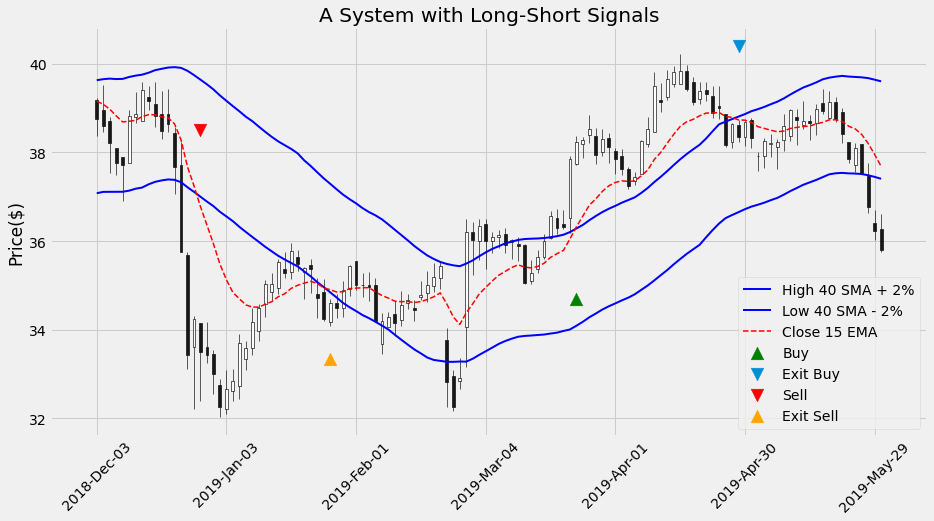

In [17]:
plot_system2_sig(df2['2018-12-01':'2019-05-30'])

We apply the same calculation as before to obtain the strategy's return:

In [18]:
# The returns of the Buy and Hold strategy:
df2['Hold'] = np.log(df2['Adj Close'] / df2['Adj Close'].shift(1))

# The returns of the Moving Average strategy:
df2['Strategy'] = df2['Position'].shift(1) * df2['Hold']

# We need to get rid again of the NaN generated in the first row:
df2.dropna(inplace=True)

returns2 = np.exp(df2[['Hold', 'Strategy']].sum()) -1

print(f"Buy and hold return: {round(returns2['Hold']*100,2)}%")
print(f"Strategy return: {round(returns2['Strategy']*100,2)}%")

Buy and hold return: 17.04%
Strategy return: -5.25%


As before, we can annualize the returns:

In [19]:
n_days2 = len(df2)

# Assuming 252 trading days in a year:
ann_returns2 = 252 / n_days2 * returns2

print(f"Buy and hold annualized return: {round(ann_returns2['Hold']*100,2)}%")
print(f"Strategy annualized return: {round(ann_returns2['Strategy']*100,2)}%")

Buy and hold annualized return: 3.52%
Strategy annualized return: -1.09%


In this case, our strategy is actually worse better than the *buy and hold* strategy.

You might have noted that I used the **unadjusted price series** to evaluate the signals, while I kept using adjusted prices to calculate returns. Evaluating signals using non-adjusted prices has the risk to introduce false triggers whenever dividends, splits, or other corporate actions create a gap in the prices. Here, I just used a price series that is commonly available and that everyone can download for free. If all we have is unadjusted prices, we should correct our backtest using all the information available about corporate actions.  

## Conclusion
Is that all we need to perform backtests and to select strategies we can rely on? Definitely not: in our backtests, we made (although implicitly) some assumptions and simplifications that can substantially affect our results.
To start with, we assumed that a stock can be bought at exactly the closing price of the day the signal is triggered. This is, in reality,  not guaranteed: the actual price will be somewhere in the range of the day after the signal occurred. Then, **transaction costs** have to be included. For example:
- Brokerage **fees** are paid to execute and clear our orders.
- The **spread** between Bid and Ask price is a cost component.
- If we buy on leverage we need to pay **interest**. Similarly, if we borrow shares to sell short we need to pay interest on that loan.

Some of those factors are more evident than others to understand and include in the model.

When we want to evaluate the performance of a system and compare it to that of other systems, the return over a given period is only one of the many **performance and risk metrics** that we want to consider. Some examples are:

- Percentage of *Winning Trades vs Losing Trades*.
- Maximum [Drawdown](https://www.investopedia.com/terms/d/drawdown.asp): the difference between the high point in our cumulated profits and the low point.
- *Standard Deviation* and *Sharpe Ratio* of the returns.
- [Risk/Reward ratio](https://www.investopedia.com/terms/r/riskrewardratio.asp), this is the prospective return we can earn from a trade for each dollar invested.

The barebone backtests we have just introduced provides the starting point to calculate all those metrics and to build a more realistic system.

For all those reasons, unless we want to build a complete system from scratch, if we need to backtest a strategy realistically the best option is most probably to use a complete solution like *Zipline* or *Backtrader*. However, I still keep learning a lot about indicators and strategies when writing a backtest from scratch, and this is an exercise I definitely recommend.